# fmri Portfolio 4

__Goal__ <br>
The goal is to make a multivariate classification on fmri data on one subject (hence a one level analysis).
To do so we must first make a one level model (glm/LSA(?)) - this will provide us the beta valus of each voxel to each signal. These are our y's ($y = X\beta$) that we want for a classifier to be able to predict. The idea is that there hopefully is a sufficient contrast in the signal when processing negative versus positive words, which will let the classifier predict which word the participant saw. 

In [43]:
from pathlib import Path

import nilearn
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import first_level_from_bids
from nilearn.masking import apply_mask

import nibabel as nib

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from nilearn.glm.first_level import make_first_level_design_matrix

# Local import
from paaby_utils import load_prep_events, load_prep_confounds, fit_first_level_subject

#### Obtain FirstLevelModels

In [5]:

bids_dir = Path("/work/816119/InSpePosNegData/BIDS_2023E")
subject = "0116"

In [6]:
flm, events, confounds, masks = fit_first_level_subject(subject, bids_dir) 

Computing run 1 out of 6 runs (go take a coffee, a big one)
/home/ucloud/.local/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:76: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn(
Computing run 2 out of 6 runs (464 seconds remaining)
Computing run 3 out of 6 runs (371 seconds remaining)
/home/ucloud/.local/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:76: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn(
Computing run 4 out of 6 runs (280 seconds remaining)
/home/ucloud/.local/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:76: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn(
Computing run 5 out of 6 runs (184 seconds remaining)
/home/ucloud/.local/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:76:

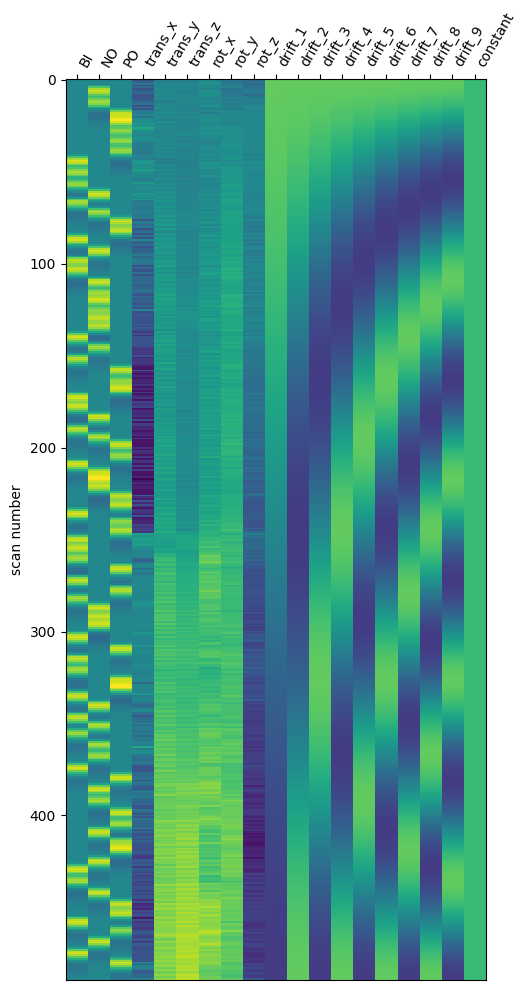

In [8]:
# plot the design matrix
design_matrix = flm.design_matrices_[1]
plot_design_matrix(design_matrix)
plt.show()

Above is the matrix of each sample (row) and the conditions (columns). There are 6 of these matrices one for each block - this means that when we are looking at the first matrix [0], **NS** (negative self) and **PS** (positive self) are our conditions of interest, whereas it is matrix [1] is **NS** (negative other) and **PS** (positive other). This means that the only thing similar across all blocks are positive/negative words - making them the most obvious to model. I believe **BI** is the button index for when press the button. 

In [21]:
design_matrix.shape

(490, 19)

The shape of the matrix are 490 (number of samples in one block) and 19 (conditions). The drift conditions relates to something about frequency bands in the data, which together can be deduced to the signal we look at - I haven't completely understood that part. 

#### Look at the events, confounds and masks:
**Events** is a list of 6 elements - each representing a block. It contains the `onset`, `duration` and `trial type` of each of the 90 trials the subjects went through in the six blocks

**Confounds** is 490 rows x 6 columns. the columns are: `trans_x,trans_y,trans_z,rot_x,rot_y,rot_z`. It is a list with timepoint-by-timepoint confounds (such as motion parameters). 

**Masks** is a binary image indicating which voxels are brain and which are not, and is in a `nibabel` format. 

In [50]:
events[4]
confounds
masks # also known as func_mask in notebook13 


### now these needs to be on the right format: 

OKAY UDFORDRINGEN HER ER AT VORES ER LISTER DER MINDER LIDT OM DICTIONARIES - DERES ER PD FRAMES, SÅ PLOT, KLASSIFICERING OSV. BLIVER MÅSKE BØVL????

In [54]:
### EVENTS: 
events_df_filt = events.query("trial_type != 'response' and trial_type != 'rating'")
events_df_filt = events_df_filt.loc[:, ['onset', 'duration', 'trial_type']]
confs_df_filt = confs_df.loc[:, ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]

##Check dataframes if you want:
print(events_df_filt)
print(confs_df_filt.shape)

AttributeError: 'list' object has no attribute 'query'

#### Classification

In [46]:
# 
in_spe = []
for col in events['trial_type']:
    img = flm.compute_contrast(col, output_type='effect_size')
    in_spe.append(apply_mask(img, func_mask))
    
in_spe = np.vstack(in_spe)

TypeError: list indices must be integers or slices, not str

In [41]:
# make frame_times
T = 1 # TR
sample_length = design_matrix.shape[0]
t_fmri = np.linspace(0, T, sample_length, endpoint=False)
t_fmri

array([0.        , 0.00204082, 0.00408163, 0.00612245, 0.00816327,
       0.01020408, 0.0122449 , 0.01428571, 0.01632653, 0.01836735,
       0.02040816, 0.02244898, 0.0244898 , 0.02653061, 0.02857143,
       0.03061224, 0.03265306, 0.03469388, 0.03673469, 0.03877551,
       0.04081633, 0.04285714, 0.04489796, 0.04693878, 0.04897959,
       0.05102041, 0.05306122, 0.05510204, 0.05714286, 0.05918367,
       0.06122449, 0.06326531, 0.06530612, 0.06734694, 0.06938776,
       0.07142857, 0.07346939, 0.0755102 , 0.07755102, 0.07959184,
       0.08163265, 0.08367347, 0.08571429, 0.0877551 , 0.08979592,
       0.09183673, 0.09387755, 0.09591837, 0.09795918, 0.1       ,
       0.10204082, 0.10408163, 0.10612245, 0.10816327, 0.11020408,
       0.1122449 , 0.11428571, 0.11632653, 0.11836735, 0.12040816,
       0.12244898, 0.1244898 , 0.12653061, 0.12857143, 0.13061224,
       0.13265306, 0.13469388, 0.13673469, 0.13877551, 0.14081633,
       0.14285714, 0.14489796, 0.14693878, 0.14897959, 0.15102

In [44]:
lsa_dm = make_first_level_design_matrix(
    frame_times=t_fmri,  # we defined this earlier for interpolation!
    events=events_sim,
    hrf_model='glover',
    drift_model=None  # assume data is already high-pass filtered
)

NameError: name 'events_sim' is not defined